In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pickle
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from cool_image_functions import *
%matplotlib inline

In [2]:
# Do only once and store the result
caliberate_camera()

(array([[  1.15777818e+03,   0.00000000e+00,   6.67113857e+02],
        [  0.00000000e+00,   1.15282217e+03,   3.86124583e+02],
        [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00]]),
 array([[-0.24688507, -0.02373156, -0.00109831,  0.00035107, -0.00259866]]))

In [3]:
def processing_pipeline(current_image):
    
    # load the caliberation result and use for undistorting any imag
    dist_pickle = pickle.load( open( "camera_cal/mtx_dist_pickle.p", "rb" ) )
    mtx = dist_pickle["mtx"]
    dist = dist_pickle["dist"]
    
    # undistort
    img = current_image
    image_shape = img.shape
    undistorted_img = cal_undistort(img, mtx, dist)
    
    #color_binary to check the individual contributions of x_gradient and color channel
    processed_image, color_binary = apply_color_and_gradient_threshold(undistorted_img, (170, 255), (30, 100))
    
    # Perform Masking
    points = np.array([[(0,image_shape[0]),(550, 470), (700, 470), (image_shape[1],image_shape[0])]], dtype=np.int32)
    masked_image = mask_this_image(processed_image, points)
    
    # Warping: Perspective Transformation
    src = np.float32(
    [[120, 720],
     [550, 470],
     [700, 470],
     [1160, 720]])

    dst = np.float32(
    [[200,720],
     [200,0],
     [1080,0],
     [1080,720]])
    warped_image, Minv = transform_perspective(src, dst, masked_image, image_shape)
    
    # Fit a polynomial on lane lines
    leftx, lefty, rightx, righty, out_img, nonzerox, nonzeroy, left_lane_inds, right_lane_inds   = extract_pixel_positions(warped_image)
    
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, warped_image.shape[0]-1, warped_image.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Determine curvature of the lane
    y_eval = 500
    left_curverad = np.absolute(((1 + (2 * left_fit[0] * y_eval + left_fit[1])**2) ** 1.5) /(2 * left_fit[0]))
    right_curverad = np.absolute(((1 + (2 * right_fit[0] * y_eval + right_fit[1]) ** 2) ** 1.5) /(2 * right_fit[0]))
    curvature = (left_curverad + right_curverad) / 2
    centre = center(719, left_fit, right_fit)
    
    # Plot result on the road
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped_image).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image_shape[1], image_shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undistorted_img, 1, newwarp, 0.3, 0)
    
    # Write curvature on the image
    write_data_on_image(result, curvature=curvature, vehicle_position=centre)

    return result
    

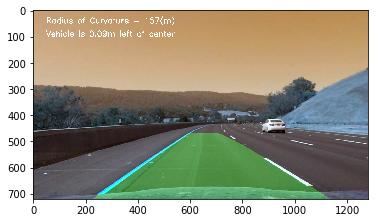

In [4]:
current_image = cv2.imread('test_images/test3.jpg')
result = processing_pipeline(current_image)
plt.imshow(result)

In [5]:
output = 'project_output_colour.mp4'
input_clip = VideoFileClip("project_video.mp4")
output_clip = input_clip.fl_image(processing_pipeline) #NOTE: this function expects color images!!
%time output_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_output_colour.mp4
[MoviePy] Writing video project_output_colour.mp4


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [10:56<00:00,  1.20it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output_colour.mp4 

Wall time: 11min 2s
